# Healthcare Fraud Detection

### Author: Huizhe (Sunny) Zhu- hz2657

Medical charges vary widely by region and type of work and other factors. This project aims to claim a doctor who charges high a fraud. We need to conclude what is a fair comparison, by considering the type of medical work (DRG) and state, 

First, we construct features/variables to identify fraud. Then, we use Kmeans clustering method to identify outliers. 

Dataset description: https://data.cms.gov/Medicare-Inpatient/National-Summary-of-Inpatient-Charge-Data-by-Medic/efwk-h4x3

## 0. load packages, import dataset 

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('inpatientCharges.csv')

**Variable description**

- DRG Definition: Classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.

- Total discharges: The number of discharges billed by the provider for inpatient hospital services. When you leave a hospital after treatment, you go through a process called hospital discharge.

- Average Covered Charges = Total Covered Charge Amount / Total Discharges,  Total Covered Charge Amount = the sum of all covered charges, Covered Charges: Charges for covered services that your health plan paid for. 

- Average Total Payments = Total Payments / Total Discharges,   Payment is the amount a hospital actually receives for providing patient care. This is the actual amount paid to a hospital by consumers, insurers or governments. 

- Average Medicare Payments = Medicare Payment Amount / Total Discharges,  Medicare Payment Amount: The average amount that Medicare pays to the provider for Medicare's share of the MS-DRG.

In [3]:
# put rows have the same provider id together, sort values for provider id 
df = df.sort_values('Provider Id', ascending = True)
df.head(3)

DRG Definition  Provider Id  \
0       039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
63035           292 - HEART FAILURE & SHOCK W CC        10001   
147575    812 - RED BLOOD CELL DISORDERS W/O MCC        10001   

                           Provider Name Provider Street Address  \
0       SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
63035   SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
147575  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   

       Provider City Provider State  Provider Zip Code  \
0             DOTHAN             AL              36301   
63035         DOTHAN             AL              36301   
147575        DOTHAN             AL              36301   

       Hospital Referral Region Description   Total Discharges   \
0                               AL - Dothan                  91   
63035                           AL - Dothan                 229   
147575                          AL - Dothan                  59   

        Average Covered Charges   Average Total Payments   \
0                      $32963.07                 $5777.24   
63035                  $23352.07                 $6045.81   
147575                 $19670.22                 $4487.89   

       Average Medicare Payments  
0                       $4763.73  
63035                   $4916.71  
147575                  $3879.84

## 1. EDA

- The dataset contains 163065 columns, 12 rows, there is no na value
- The column contains the types of clinical conditions, provider details (id, name, address, city, state, zip code), the number of discharge for a clinical condition, average coverage charged billed to insurance company, the average of total payments received from insurance company, and the average of medicare payment. 
- The last three columns are 'object', we convert last three columns to float and remove the whitespace in the column names

In [4]:
# 163065 columns, 12 rows
df.shape

(163065, 12)

In [5]:
# examine column names
df.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       ' Total Discharges ', ' Average Covered Charges ',
       ' Average Total Payments ', 'Average Medicare Payments'],
      dtype='object')

In [6]:
# check data types 
df.dtypes

DRG Definition                          object
Provider Id                              int64
Provider Name                           object
Provider Street Address                 object
Provider City                           object
Provider State                          object
Provider Zip Code                        int64
Hospital Referral Region Description    object
 Total Discharges                        int64
 Average Covered Charges                object
 Average Total Payments                 object
Average Medicare Payments               object
dtype: object

In [7]:
# convert last three 'object' columns to float
df[df.columns[9:]] = df[df.columns[9:]].replace('[\$,]', '', regex=True).astype(float)

# rename column names
df.columns = ['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       'Total Discharges', 'Average Covered Charges',
       'Average Total Payments', 'Average Medicare Payments']

No missing value in this dataset 

In [8]:
# by using .info(), we can see there is no na value in the dataset
df.info()

# alternatively, we can use df.isnull() to check missing values 
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163065 entries, 0 to 144651
Data columns (total 12 columns):
DRG Definition                          163065 non-null object
Provider Id                             163065 non-null int64
Provider Name                           163065 non-null object
Provider Street Address                 163065 non-null object
Provider City                           163065 non-null object
Provider State                          163065 non-null object
Provider Zip Code                       163065 non-null int64
Hospital Referral Region Description    163065 non-null object
Total Discharges                        163065 non-null int64
Average Covered Charges                 163065 non-null float64
Average Total Payments                  163065 non-null float64
Average Medicare Payments               163065 non-null float64
dtypes: float64(3), int64(3), object(6)
memory usage: 16.2+ MB


DRG Definition                          0
Provider Id                             0
Provider Name                           0
Provider Street Address                 0
Provider City                           0
Provider State                          0
Provider Zip Code                       0
Hospital Referral Region Description    0
Total Discharges                        0
Average Covered Charges                 0
Average Total Payments                  0
Average Medicare Payments               0
dtype: int64

In [9]:
# Here we can see the average and standard devition for average covered charged, average total payments, and average medicare payment
# we can see average covered charged is more than average total payments, which is more than average medicare payments 
df.describe()

Provider Id  Provider Zip Code  Total Discharges  \
count  163065.000000      163065.000000     163065.000000   
mean   255569.865428       47938.121908         42.776304   
std    151563.671767       27854.323080         51.104042   
min     10001.000000        1040.000000         11.000000   
25%    110092.000000       27261.000000         17.000000   
50%    250007.000000       44309.000000         27.000000   
75%    380075.000000       72901.000000         49.000000   
max    670077.000000       99835.000000       3383.000000   

       Average Covered Charges  Average Total Payments  \
count            163065.000000           163065.000000   
mean              36133.954224             9707.473804   
std               35065.365931             7664.642598   
min                2459.400000             2673.000000   
25%               15947.160000             5234.500000   
50%               25245.820000             7214.100000   
75%               43232.590000            11286.400000   
max              929118.900000           156158.180000   

       Average Medicare Payments  
count              163065.000000  
mean                 8494.490964  
std                  7309.467261  
min                  1148.900000  
25%                  4192.350000  
50%                  6158.460000  
75%                 10056.880000  
max                154620.810000

### Exploratory graph

In [10]:
# graph 1: distribution of total discharges 
import matplotlib.pyplot as plt
plt.hist(df['Total Discharges'], 30, range=[0, 500],  align='mid')
plt.ylabel('total discharges', fontsize=14)
plt.title('total discharges distribution', fontsize=14)

Text(0.5, 1.0, 'total discharges distribution')

Text(0.5, 1.0, 'Average Covered Charges')

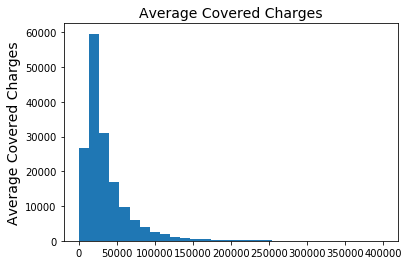

In [11]:
# graph 2: distribution of Average Covered Charges
plt.hist(df['Average Covered Charges'], 30, range=[0, 400000],  align='mid')
plt.ylabel('Average Covered Charges', fontsize=14)
plt.title('Average Covered Charges', fontsize=14)

we can see from the graph that average total payments tend to be 10 times less than average covered charges

Text(0.5, 1.0, 'Average Total Payments')

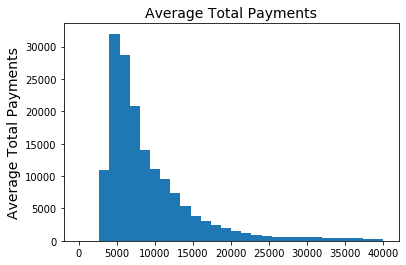

In [12]:
# graph 3: distribution of Average Total Payments
plt.hist(df['Average Total Payments'], 30, range=[0, 40000],  align='mid')
plt.ylabel('Average Total Payments', fontsize=14)
plt.title('Average Total Payments', fontsize=14)

we can see from the graph that the distribution of average Medicare payments is very similar to average total payments

Text(0.5, 1.0, 'Average Medicare Payments')

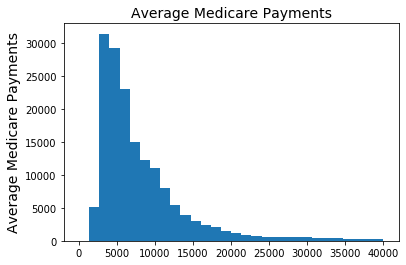

In [13]:
# graph 4: distribution of Average Medicare Payments
plt.hist(df['Average Medicare Payments'], 30, range=[0, 40000],  align='mid')
plt.ylabel('Average Medicare Payments', fontsize=14)
plt.title('Average Medicare Payments', fontsize=14)

**Average covered charged by state**

- California has the highest 'Average Covered Charges'

Text(0.5, 1.0, 'Average Covered Payment Hospital Received by State')

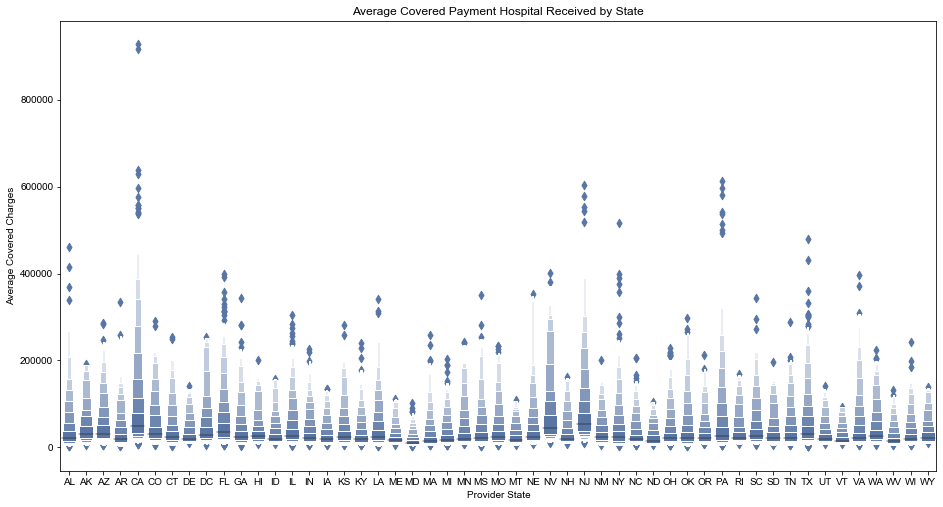

In [14]:
# graph 5: Average Covered Charges by State
import seaborn as sns
import matplotlib.pyplot as plt

a4_dims = (15.7, 8.27)   # default figure size 
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style="whitegrid")
sns.boxenplot(x="Provider State", y="Average Covered Charges",
              color="b", scale="linear", data=df,ax=ax)
ax.set_title('Average Covered Payment Hospital Received by State')

**Average total payment recieved by hospitals by state**

- New York and California has the highest 'Average Total Payment'

Text(0.5, 1.0, 'Average Total Payment Hospitals received by State')

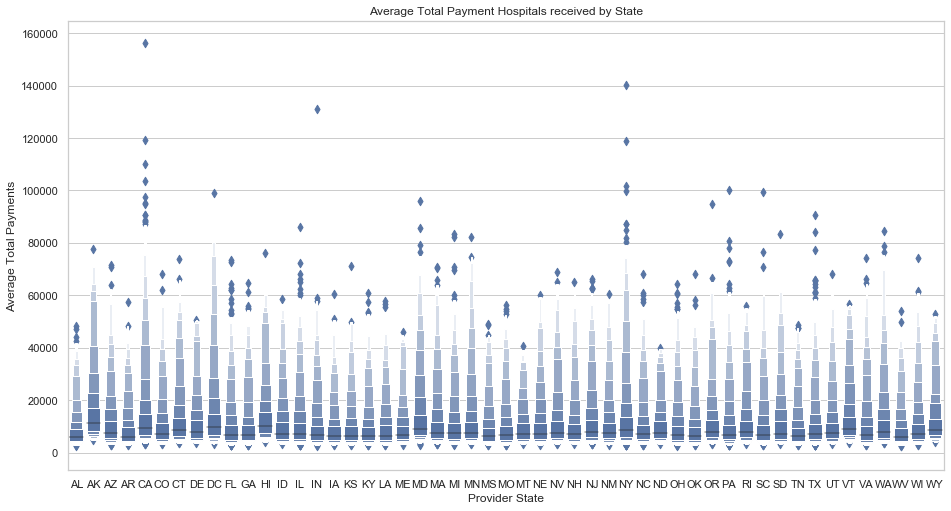

In [15]:
# graph 6: Average total payment recieved by hospitals by state

a4_dims = (15.7, 8.27)   # default figure size 
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style="whitegrid")
sns.boxenplot(x="Provider State", 
              y="Average Total Payments",
              color="b", scale="linear", data=df,ax=ax)
ax.set_title('Average Total Payment Hospitals received by State')

**Average total payment recieved by hospitals by state**

- New York, California, and Texas have the highest 'Average Medicare Payments' received from government. 

Text(0.5, 1.0, 'Average Medicare Payments Hospitals received by State')

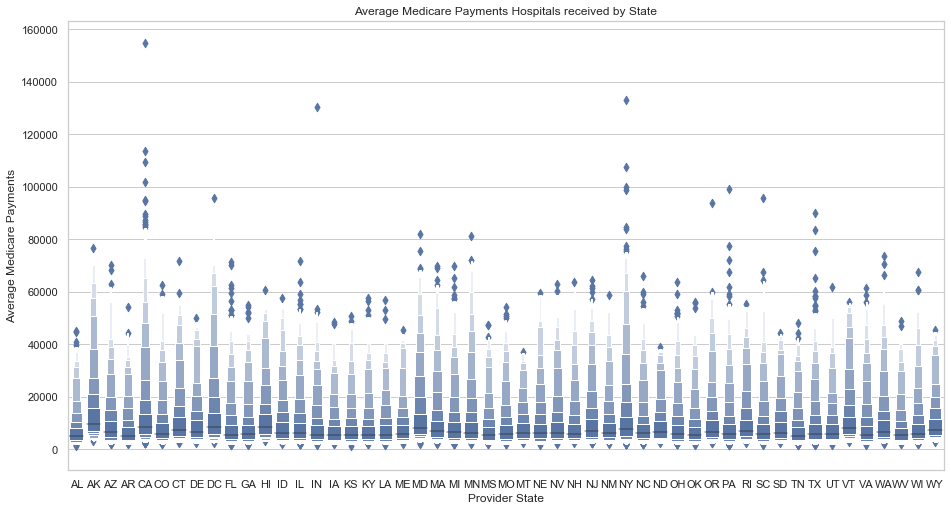

In [16]:
# graph 7: Average total payment recieved by hospitals by state

a4_dims = (15.7, 8.27)   # default figure size 
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style="whitegrid")
sns.boxenplot(x="Provider State", 
              y="Average Medicare Payments",
              color="b", scale="linear", data=df, ax=ax)
ax.set_title('Average Medicare Payments Hospitals received by State')

# 2. construct features

we use aggregation strategy to generate features: 

we use median, given the dataset has extreme values

--- discharge by provider 
1. total number of discharge by provider 
- group by 'Provider Id', sum('Total Discharges')

--- ratio by clinical condition ---- 
2. ratio of average coverage by a provider / median coverage for this clinical condition in the state 
- group by 'Provider State', median('Average Covered Charges')

3. ratio of average total payment to a provider/ median payment for this clinical condition in the state 
- group by 'Provider State', median('Average Covered Charges')

4. ratio of average total medicard coverage paid to a provider/ median medicare coverage for this clinical condition in the state 
- group by 'Provider State', median('Average Covered Charges')

--- ratio of discharge by city ---- 
5. ratio of total number of discharge by provider to the median level of discharges in the same city 

### Feature 1. total number of discharge by provider 
- group by 'Provider Id', sum('Total Discharges')

Why the feature can identify fraud: we can examine by selected city, which hospital has extreme number of total discharges. We can further examine the outliers. 

In [17]:
# create variable: discharge_by_provider
discharge_by_provider = df.groupby(['Provider Name', 'Provider Id', 'Provider City'])['Total Discharges'].sum()
discharge_by_provider = pd.DataFrame(discharge_by_provider)
discharge_by_provider.columns = ['discharge_by_provider']

df2 = pd.merge(df, discharge_by_provider, how='left', on=['Provider Name', 'Provider Id', 'Provider City'])
df2.head(2)

DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1          292 - HEART FAILURE & SHOCK W CC        10001   

                      Provider Name Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   
1  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   

  Provider State  Provider Zip Code Hospital Referral Region Description  \
0             AL              36301                          AL - Dothan   
1             AL              36301                          AL - Dothan   

   Total Discharges  Average Covered Charges  Average Total Payments  \
0                91                 32963.07                 5777.24   
1               229                 23352.07                 6045.81   

   Average Medicare Payments  discharge_by_provider  
0                    4763.73                   5405  
1                    4916.71                   5405

In [18]:
# bring index to columns 
discharge_by_provider = discharge_by_provider.reset_index()

# select city: NEW YORK
selected = discharge_by_provider.loc[discharge_by_provider['Provider City'] == 'NEW YORK']

# here we can see the total number of discharge by provider in New York 
selected.head(2)

Provider Name  Provider Id Provider City  \
225    BELLEVUE HOSPITAL CENTER       330204      NEW YORK   
243  BETH ISRAEL MEDICAL CENTER       330169      NEW YORK   

     discharge_by_provider  
225                   1324  
243                  10395

There are 11 providers in New York, from the graph below we can see the number of discharges for each provider in NYC.

From the graph we can see, New York Presbyterian hospital has the most number of discharges. 

In [19]:
# data visualization
# select city = 'New York'
# x: Provider Name
# y: discharge_by_provider
import plotly
import plotly.express as px

fig = px.scatter(selected, x="Provider Name", y="discharge_by_provider",  color = 'discharge_by_provider', size = 'discharge_by_provider',
                 title = "Total number of discharge for providers in New York",
                  size_max=60,width=800, height=500)
fig.show()

#sns.set(style="whitegrid")
#sns.boxplot(x="Provider Name", y="discharge_by_provider",
           #    data=selected_df2)

In [20]:
# examine which city is included in the dataset
#for i in df2['Provider City'].unique():
#    print(i)

### ----- the following are improved/revised features -----

### Feature 2. ratio of average coverage by a provider / median coverage for this clinical condition in the state 
- group by 'DRG Definition', 'Provider State', median('Average Covered Charges')

Why the feature can identify fraud: we can examine by selected city, the ratio of average coverage for one clinical condition to the average of coverage for that clinical condition in the state

In [21]:
# create variable: average_coverage_by_DRG_by_state
median_coverage_by_DRG_by_state = df2.groupby(['DRG Definition', 'Provider State'])['Average Covered Charges'].median()

# create average spending group by agency and merchant category 
median_coverage_by_DRG_by_state = pd.DataFrame(median_coverage_by_DRG_by_state)
median_coverage_by_DRG_by_state.columns = ['median_coverage_by_DRG_by_state']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, median_coverage_by_DRG_by_state, how='left', on=['DRG Definition', 'Provider State'])
df2.head(5)

# Feature 2: ratio of amount spending and avergae spending by Description of transaction 
df2['ratio_coverage_by_state'] = df2['Average Covered Charges'] / df2.median_coverage_by_DRG_by_state
df2.head(2)

DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1          292 - HEART FAILURE & SHOCK W CC        10001   

                      Provider Name Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   
1  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   

  Provider State  Provider Zip Code Hospital Referral Region Description  \
0             AL              36301                          AL - Dothan   
1             AL              36301                          AL - Dothan   

   Total Discharges  Average Covered Charges  Average Total Payments  \
0                91                 32963.07                 5777.24   
1               229                 23352.07                 6045.81   

   Average Medicare Payments  discharge_by_provider  \
0                    4763.73                   5405   
1                    4916.71                   5405   

   median_coverage_by_DRG_by_state  ratio_coverage_by_state  
0                        28523.390                 1.155651  
1                        16345.925                 1.428617

In [22]:
# select DRG Definition = '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC', city = 'New York'
selected1 = df2.loc[df2['Provider City'] == 'NEW YORK']
selected2 = selected1.loc[selected1['DRG Definition'] == '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC']

There are 5 providers in New York provides '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC' discharge, from the graph below we can see NYU Hospitals Centers have 1.8 times higher coverage on this clinical condition compared to the average level in New York State. 

In [23]:
fig = px.scatter(selected2, x="Provider Name", y="ratio_coverage_by_state",  color = 'ratio_coverage_by_state', size = 'ratio_coverage_by_state',
                 title = "Ratio of coverage for selected clinical condition to median in New York",
                  size_max=60,width=800, height=500)
fig.show()

### Feature 3. ratio of average total payment to a provider/ median for this clinical condition in the state 
- group by 'DRG Definition', 'Provider State', median('Average Covered Charges')


Why the feature can identify fraud: 

- we can examine the actual payment to each provider in selected city for selected clinical condition, and identify outliers by the ratio. 

In [24]:
# create variable: average_coverage_by_DRG_by_state
median_payment_by_DRG_by_state = df2.groupby(['DRG Definition', 'Provider State'])['Average Total Payments'].median()

# create average spending group by agency and merchant category 
median_payment_by_DRG_by_state = pd.DataFrame(median_payment_by_DRG_by_state)
median_payment_by_DRG_by_state.columns = ['median_payment_by_DRG_by_state']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, median_payment_by_DRG_by_state, how='left', on=['DRG Definition', 'Provider State'])

# Feature 2: ratio of amount spending and avergae spending by Description of transaction 
df2['ratio_payment_by_state'] = df2['Average Total Payments'] / df2.median_payment_by_DRG_by_state
df2.head(2)

DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1          292 - HEART FAILURE & SHOCK W CC        10001   

                      Provider Name Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   
1  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   

  Provider State  Provider Zip Code Hospital Referral Region Description  \
0             AL              36301                          AL - Dothan   
1             AL              36301                          AL - Dothan   

   Total Discharges  Average Covered Charges  Average Total Payments  \
0                91                 32963.07                 5777.24   
1               229                 23352.07                 6045.81   

   Average Medicare Payments  discharge_by_provider  \
0                    4763.73                   5405   
1                    4916.71                   5405   

   median_coverage_by_DRG_by_state  ratio_coverage_by_state  \
0                        28523.390                 1.155651   
1                        16345.925                 1.428617   

   median_payment_by_DRG_by_state  ratio_payment_by_state  
0                        5658.330                1.021015  
1                        5683.825                1.063687

In [25]:
# select DRG Definition = '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC', city = 'New York'
selected1 = df2.loc[df2['Provider City'] == 'NEW YORK']
selected2 = selected1.loc[selected1['DRG Definition'] == '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC']

There are 5 providers in New York provides '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC' discharge.

From the graph below we can see New York Presbyterian hospital received approximately 1.5 times higher payment on the selected clinical condition compared to the average level in New York State. 

In [26]:
fig = px.scatter(selected2, x="Provider Name", y="ratio_payment_by_state",  color = 'ratio_payment_by_state', size = 'ratio_payment_by_state',
                 title = "Ratio of actual payment to hospital for selected clinical condition to median in New York",
                  size_max=60,width=800, height=500)
fig.show()

### Feature 4. ratio of average total medicard coverage paid to a provider/ median medicare coverage for this clinical condition in the state 
- group by 'Provider State', median('Average Covered Charges')

Why the feature can identify fraud: we can examine which provider received most medicare payment, and examine the possibility of medicare fraud. 

In [27]:
# create variable: average_medicare_by_DRG_by_state
median_medicare_by_DRG_by_state = df2.groupby(['DRG Definition', 'Provider State'])['Average Medicare Payments'].median()

# create average spending group by agency and merchant category 
median_medicare_by_DRG_by_state = pd.DataFrame(median_medicare_by_DRG_by_state)
median_medicare_by_DRG_by_state.columns = ['median_medicare_by_DRG_by_state']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, median_medicare_by_DRG_by_state, how='left', on=['DRG Definition', 'Provider State'])

# Feature 2: ratio of amount spending and avergae spending by Description of transaction 
df2['ratio_medicare_by_state'] = df2['Average Medicare Payments'] / df2.median_medicare_by_DRG_by_state
df2.head(2)

DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1          292 - HEART FAILURE & SHOCK W CC        10001   

                      Provider Name Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   
1  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   

  Provider State  Provider Zip Code Hospital Referral Region Description  \
0             AL              36301                          AL - Dothan   
1             AL              36301                          AL - Dothan   

   Total Discharges  Average Covered Charges  Average Total Payments  \
0                91                 32963.07                 5777.24   
1               229                 23352.07                 6045.81   

   Average Medicare Payments  discharge_by_provider  \
0                    4763.73                   5405   
1                    4916.71                   5405   

   median_coverage_by_DRG_by_state  ratio_coverage_by_state  \
0                        28523.390                 1.155651   
1                        16345.925                 1.428617   

   median_payment_by_DRG_by_state  ratio_payment_by_state  \
0                        5658.330                1.021015   
1                        5683.825                1.063687   

   median_medicare_by_DRG_by_state  ratio_medicare_by_state  
0                         4471.680                 1.065311  
1                         4849.605                 1.013837

In [28]:
# select DRG Definition = '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC', city = 'New York'
selected1 = df2.loc[df2['Provider City'] == 'NEW YORK']
selected2 = selected1.loc[selected1['DRG Definition'] == '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC']

There are 5 providers in New York provides '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC' discharge.

From the graph below we can see BETH ISREAL MEDICAL CENTER received approximately 1.5 times higher payment on the selected clinical condition compared to the average level in New York State, and it is the highest compared to other hospitals. 

In [29]:
fig = px.scatter(selected2, x="Provider Name", y="ratio_medicare_by_state",  color = 'ratio_medicare_by_state', size = 'ratio_medicare_by_state',
                 title = "Ratio of medicare payment to hospital for selected clinical condition to median in New York",
                  size_max=60,width=800, height=500)
fig.show()

### Feature 5. ratio of total number of discharge by provider to the avergae level of discharges in the same city 
- group by 'Provider Id', 'Provider City' , sum('Total Discharges')

Why the feature can identify fraud: 
- we can examine by selected city, which hospital has extreme number of total discharges. We can further examine the outliers. 

In [30]:
# create variable: average_medicare_by_DRG_by_state
median_discharge_by_provider_by_city = df2.groupby(['Provider Id', 'Provider City'])['Total Discharges'].median()

# create average spending group by agency and merchant category 
median_discharge_by_provider_by_city = pd.DataFrame(median_discharge_by_provider_by_city)
median_discharge_by_provider_by_city.columns = ['median_discharge_by_provider_by_city']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, median_discharge_by_provider_by_city, how='left', on=['Provider Id', 'Provider City'])

# Feature 5
df2['ratio_average_discharge_by_provider_by_city'] = df2['Total Discharges'] / df2.median_discharge_by_provider_by_city
df2.head(2)

DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1          292 - HEART FAILURE & SHOCK W CC        10001   

                      Provider Name Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   
1  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE        DOTHAN   

  Provider State  Provider Zip Code Hospital Referral Region Description  \
0             AL              36301                          AL - Dothan   
1             AL              36301                          AL - Dothan   

   Total Discharges  Average Covered Charges  ...  Average Medicare Payments  \
0                91                 32963.07  ...                    4763.73   
1               229                 23352.07  ...                    4916.71   

   discharge_by_provider  median_coverage_by_DRG_by_state  \
0                   5405                        28523.390   
1                   5405                        16345.925   

   ratio_coverage_by_state  median_payment_by_DRG_by_state  \
0                 1.155651                        5658.330   
1                 1.428617                        5683.825   

   ratio_payment_by_state  median_medicare_by_DRG_by_state  \
0                1.021015                         4471.680   
1                1.063687                         4849.605   

   ratio_medicare_by_state  median_discharge_by_provider_by_city  \
0                 1.065311                                  37.5   
1                 1.013837                                  37.5   

   ratio_average_discharge_by_provider_by_city  
0                                     2.426667  
1                                     6.106667  

[2 rows x 21 columns]

In [31]:
# select city = 'New York'
selected1 = df2.loc[df2['Provider City'] == 'NEW YORK']
selected1.head(2)

DRG Definition  Provider Id  \
97829  189 - PULMONARY EDEMA & RESPIRATORY FAILURE       330024   
97830            390 - G.I. OBSTRUCTION W/O CC/MCC       330024   

              Provider Name   Provider Street Address Provider City  \
97829  MOUNT SINAI HOSPITAL  ONE GUSTAVE L LEVY PLACE      NEW YORK   
97830  MOUNT SINAI HOSPITAL  ONE GUSTAVE L LEVY PLACE      NEW YORK   

      Provider State  Provider Zip Code Hospital Referral Region Description  \
97829             NY              10029                       NY - Manhattan   
97830             NY              10029                       NY - Manhattan   

       Total Discharges  Average Covered Charges  ...  \
97829                34                 28760.47  ...   
97830                41                 15255.97  ...   

       Average Medicare Payments  discharge_by_provider  \
97829                   14384.91                  10809   
97830                    6599.14                  10809   

       median_coverage_by_DRG_by_state  ratio_coverage_by_state  \
97829                        27941.520                 1.029309   
97830                        15067.565                 1.012504   

       median_payment_by_DRG_by_state  ratio_payment_by_state  \
97829                         9478.50                1.600821   
97830                         4880.75                1.570099   

       median_medicare_by_DRG_by_state  ratio_medicare_by_state  \
97829                         8635.470                 1.665794   
97830                         3544.825                 1.861626   

       median_discharge_by_provider_by_city  \
97829                                  78.0   
97830                                  78.0   

       ratio_average_discharge_by_provider_by_city  
97829                                     0.435897  
97830                                     0.525641  

[2 rows x 21 columns]

From the graph we can see, NYU Hospital Center has 10 times total discharges compared to the average level of discharges of NYC

In [32]:
fig = px.scatter(selected1, x="Provider Name", y="ratio_average_discharge_by_provider_by_city",  color = 'ratio_average_discharge_by_provider_by_city', size = 'ratio_average_discharge_by_provider_by_city',
                 title = "Ratio of total number of discharge by provider to the median discharges in New York",
                  size_max=60,width=900, height=600)
fig.show()

# 3. Dimension reduction 

- Standardize columns
- Apply PCA, choose number of components

### 3.1  Principal Component Analysis (PCA)
- apply dimension reduction to get lower dimensions

In [33]:
# Standardization
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df3 = df2.loc[:, ['ratio_coverage_by_state', 'ratio_payment_by_state',
           'ratio_medicare_by_state', 'ratio_average_discharge_by_provider_by_city']]

# Standardize the data to have a mean of 0 and a variance of 1
X_std = StandardScaler().fit_transform(df3)

The graph below shows that 

- the first 3 components explain 96% of the variance in our data. 

- the first 2 components explain 76% of the variance in our data. 

- the first component explains 51% of variance in the data. 

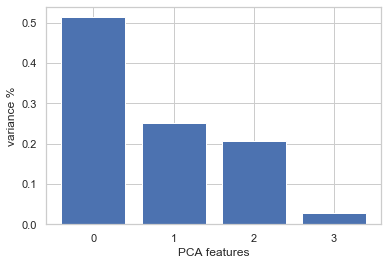

In [34]:
# Create a PCA instance: pca
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'cummulative explained variance')

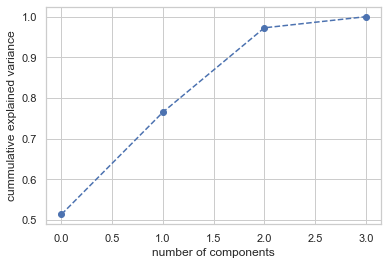

In [35]:
#plt.figure(gigsize = (10,8))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('number of components')
plt.ylabel('cummulative explained variance')

Text(0, 0.5, 'PCA 2')

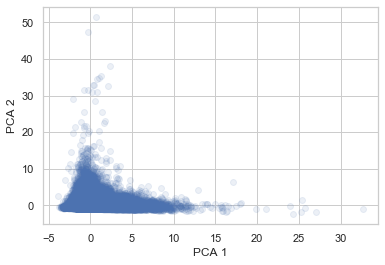

In [36]:
# plot first 2 compnents in 2 dimensional space 
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [37]:
# view PCA compnenent
PCA_components

0         1         2         3
0       0.008313  0.702514 -0.067051 -0.134598
1       0.244258  3.274430 -0.187928  0.147413
2       0.167474  0.238419 -0.722821 -0.255260
3      -0.172278 -0.125771  0.015863 -0.190655
4       0.241183 -0.495489 -0.844577 -0.399736
...          ...       ...       ...       ...
163060 -0.779733 -0.059684 -1.353113 -0.212313
163061 -1.124453  0.029243 -0.662986 -0.182059
163062 -0.864445 -0.026153 -1.236658 -0.332374
163063 -2.196414 -0.360120  0.364601 -0.102506
163064 -1.405246 -0.119990 -0.897439  0.516078

[163065 rows x 4 columns]

# 4. Clustering by K-means

we will use k-means clustering to view the top 3 PCA components, given the first 3 components explain 96% of the variance in our data. 

From the graph, we can see the elbow point is when k = 2 and k = 4, however we will also examine other number of clusters 

### examine optimal number of clusters 

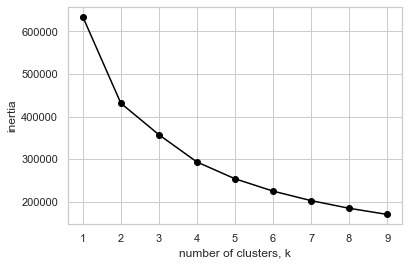

In [38]:
# determine the best number of clusters
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

###  write a function to get summary statistics table for each value of k

In [46]:
# write a function to get summary statistics for each k 
def identify_outlier_by_kmeans(k, PCA_components, num_component):
    from sklearn.cluster import KMeans
    # implement k means 
    kmean = KMeans(n_clusters = k, random_state=1)
    # fit data: we only use the first 3 components
    kmean.fit(PCA_components.iloc[:,:num_component])
    df_kmean = df2.copy()
    # create new column and add it to original dataset 
    df_kmean['cluster']=kmean.labels_   
    # count by cluster
    table1 = pd.DataFrame(df_kmean['cluster'].value_counts())
    table1.columns = ['count']
    # summary statistics
    table2 = df_kmean.loc[:,['Total Discharges', 'Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments', 
                             'ratio_coverage_by_state','ratio_payment_by_state','ratio_medicare_by_state','ratio_average_discharge_by_provider_by_city',
                             'cluster']].groupby(['cluster']).mean()
    table3 = pd.concat([table1, table2], axis = 1)
        
    # return distribution by cluster and summary statistics
    return table3

### n_clusters = 4

- cluster 3 has the least number of observations, it has the highest dischargest
- we cannot identify outliers when k = 4

In [47]:
identify_outlier_by_kmeans(4, PCA_components, num_component=3)

count  Total Discharges  Average Covered Charges  Average Total Payments  \
0  38926         38.774161             50748.558341             9947.920368   
1  96905         32.194159             29008.936009             8873.290775   
2  17600         41.859545             45031.563048            14180.680474   
3   9634        167.063733             32497.239987             8954.769434   

   Average Medicare Payments  ratio_coverage_by_state  ratio_payment_by_state  \
0                8643.011249                 1.504880                1.076412   
1                7737.153982                 0.861874                0.962870   
2               12775.064488                 1.294605                1.502219   
3                7692.160220                 1.052547                1.006171   

   ratio_medicare_by_state  ratio_average_discharge_by_provider_by_city  
0                 1.071275                                     1.262960  
1                 0.960892                                     1.136423  
2                 1.568577                                     1.277976  
3                 1.005805                                     5.375386

### n_clusters = 5

- cluster 4 has the least number of observations, it also has the highest dischargest
- we cannot identify outliers when k = 5

In [48]:
identify_outlier_by_kmeans(5, PCA_components, num_component=3)

count  Total Discharges  Average Covered Charges  Average Total Payments  \
0  87823         32.393678             29433.611456             8687.948524   
1  10497         44.607221             49523.432904            15216.540977   
2  31682         38.338047             36364.175348            11259.766666   
3  24403         38.737327             55335.639852             9211.534370   
4   8660        173.468014             32903.266605             9087.584441   

   Average Medicare Payments  ratio_coverage_by_state  ratio_payment_by_state  \
0                7560.590000                 0.876134                0.941178   
1               13741.829878                 1.450143                1.615643   
2                9950.944994                 1.024824                1.190927   
3                7951.269042                 1.692404                1.036857   
4                7807.370381                 1.049546                1.003468   

   ratio_medicare_by_state  ratio_average_discharge_by_provider_by_city  
0                 0.935809                                     1.153529  
1                 1.691791                                     1.324577  
2                 1.212635                                     1.185858  
3                 1.027233                                     1.327695  
4                 1.002545                                     5.587215

### n_clusters = 6

- cluster 1 has the least number of observations, it also has the highest dischargest
- we cannot identify outliers when k = 6

In [49]:
identify_outlier_by_kmeans(6, PCA_components, num_component=3)

count  Total Discharges  Average Covered Charges  Average Total Payments  \
0  22294         36.032027             56916.500972             9358.929057   
1    903        372.973422             44507.615515            12732.280399   
2  30281         35.805555             36820.816764            11382.992167   
3  10287         45.140371             49363.429696            15230.459844   
4  82286         28.190081             29950.106824             8825.424280   
5  17014        115.610027             29143.596585             7948.219922   

   Average Medicare Payments  ratio_coverage_by_state  ratio_payment_by_state  \
0                8092.327568                 1.724932                1.042202   
1               10951.393200                 1.033832                1.020729   
2               10068.663526                 1.028327                1.196426   
3               13752.430087                 1.448832                1.620113   
4                7693.051748                 0.875187                0.940760   
5                6786.399762                 1.033053                0.991938   

   ratio_medicare_by_state  ratio_average_discharge_by_provider_by_city  
0                 1.032974                                     1.236106  
1                 1.019659                                    12.813813  
2                 1.218633                                     1.118800  
3                 1.696872                                     1.340472  
4                 0.935474                                     1.014628  
5                 0.989135                                     3.719273

### n_clusters = 7

- cluster 7 has the least number of observations, it also has the highest dischargest
- cluster 3 has the 2nd least number of observations (5%), and highest average ratio of total coverage, actual payment, and medicare payment, health providers in this group requires more attention.

In [50]:
output7 = identify_outlier_by_kmeans(7, PCA_components, num_component=3)

In [51]:
# group by cluster  
# y: last 4 columns
output7['cluster'] = [1,2,3,4,5,6,7]
output7

count  Total Discharges  Average Covered Charges  Average Total Payments  \
0  24848         36.921080             37602.831310            11795.440536   
1  57260         28.154331             26300.521589             8710.303764   
2   8310         45.255355             47650.432838            15554.044576   
3  15619        120.027851             29253.907583             8005.551484   
4  46193         31.398545             40853.139343             9200.369396   
5   9992         42.395416             67492.938561            10118.622851   
6    843        380.772242             44424.483808            12708.604781   

   Average Medicare Payments  ratio_coverage_by_state  ratio_payment_by_state  \
0               10484.797703                 1.041764                1.238025   
1                7613.910524                 0.760265                0.928702   
2               14057.471058                 1.409324                1.664992   
3                6838.877614                 1.033901                0.993966   
4                7963.408800                 1.213274                0.995755   
5                8802.942784                 2.084842                1.119151   
6               10923.651435                 1.030970                1.019702   

   ratio_medicare_by_state  ratio_average_discharge_by_provider_by_city  \
0                 1.268602                                     1.156362   
1                 0.925224                                     1.031626   
2                 1.748113                                     1.347486   
3                 0.991704                                     3.855687   
4                 0.987189                                     1.068874   
5                 1.114513                                     1.390992   
6                 1.018217                                    13.130256   

   cluster  
0        1  
1        2  
2        3  
3        4  
4        5  
5        6  
6        7

Text(0.5, 1.0, 'Plot ratios by cluster')

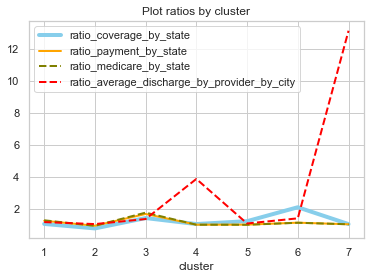

In [52]:
# multiple line plot
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output7, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output7, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.plot( 'cluster', 'ratio_medicare_by_state', data=output7, marker='', color='olive', linewidth=2, linestyle='dashed', label="ratio_medicare_by_state")
plt.plot( 'cluster', 'ratio_average_discharge_by_provider_by_city', data=output7, marker='', color='red', linewidth=2, linestyle='dashed', label="ratio_average_discharge_by_provider_by_city")
plt.legend()
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')

Text(0.5, 1.0, 'Plot ratios by cluster')

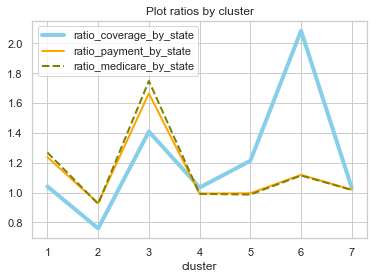

In [54]:
# # if we do not plot the variable about discharges
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output7, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output7, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.plot( 'cluster', 'ratio_medicare_by_state', data=output7, marker='', color='olive', linewidth=2, linestyle='dashed', label="ratio_medicare_by_state")
plt.legend()
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')

we found ratio_payment_by_state and ratio_medicare_by_state are very similar, so we only keep one of them, ratio_payment_by_state

Text(0.5, 1.0, 'Plot ratios by cluster')

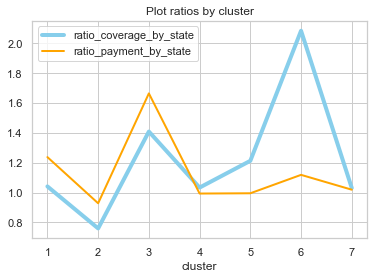

In [55]:
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output7, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output7, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.legend()
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')

In [ ]:
# percentage of cluster 2
8310/163065

### n_clusters = 8

- cluster 4 has the least number of observations (0.4%) and the highest discharges
- cluster 2 has the 2nd least number of observations (3.4%), average ratio of total coverage and actual payment, health providers in this group requires more attention.

In [56]:
output8 = identify_outlier_by_kmeans(8, PCA_components, num_component=3)
output8['cluster'] = [1,2,3,4,5,6,7,8]
output8

count  Total Discharges  Average Covered Charges  Average Total Payments  \
0  46178         28.150245             28007.758208             8575.915357   
1   5701         45.389055             48737.916418            16190.116911   
2   6382         45.354748             73845.809235            10710.124931   
3    785        389.138854             44505.688688            12742.760153   
4  29808         32.531938             47039.799033             8930.912332   
5  14769        123.428194             29517.864031             8066.482610   
6  42162         31.922466             29690.311845             9690.183257   
7  17280         39.535127             41947.373492            12868.728763   

   Average Medicare Payments  ratio_coverage_by_state  ratio_payment_by_state  \
0                7473.233857                 0.799841                0.893798   
1               14662.501845                 1.438142                1.744396   
2                9365.569002                 2.278744                1.160551   
3               10947.958051                 1.033912                1.021168   
4                7696.358079                 1.400042                0.993901   
5                6892.335292                 1.037494                0.995871   
6                8491.075109                 0.889601                1.058466   
7               11509.976519                 1.155850                1.328226   

   ratio_medicare_by_state  ratio_average_discharge_by_provider_by_city  \
0                 0.883944                                     1.041321   
1                 1.836144                                     1.357154   
2                 1.158401                                     1.451658   
3                 1.018801                                    13.465246   
4                 0.982670                                     1.136417   
5                 0.993599                                     3.952949   
6                 1.066832                                     1.057486   
7                 1.370811                                     1.219141   

   cluster  
0        1  
1        2  
2        3  
3        4  
4        5  
5        6  
6        7  
7        8

In [ ]:
# percentage of cluster 2
# 5701/163065

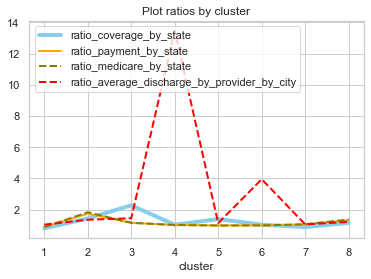

In [57]:
# group by cluster  
# y: last 4 columns
# multiple line plot
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output8, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output8, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.plot( 'cluster', 'ratio_medicare_by_state', data=output8, marker='', color='olive', linewidth=2, linestyle='dashed', label="ratio_medicare_by_state")
plt.plot( 'cluster', 'ratio_average_discharge_by_provider_by_city', data=output8, marker='', color='red', linewidth=2, linestyle='dashed', label="ratio_average_discharge_by_provider_by_city")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()


we found ratio_payment_by_state and ratio_medicare_by_state are very similar, so we only keep one of them, ratio_payment_by_state

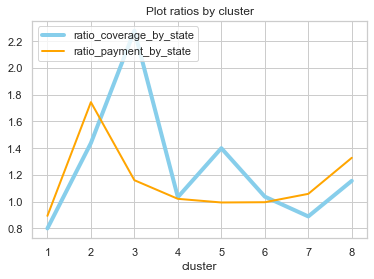

In [58]:
# if we do not plot the variable about discharges
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output8, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output8, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()

### n_clusters = 9

- cluster 8 (0.01%) and cluster 4 (9.8%) has the least number of observations and the highest discharges
- cluster 2 has the 3nd least number of observations (3.4%), and relatively highest average ratio of total coverage and actual payment, health providers in this group requires more attention.

In [59]:
output9 = identify_outlier_by_kmeans(9, PCA_components, num_component=3)
output9['cluster'] = [1,2,3,4,5,6,7,8,9]
output9

count  Total Discharges  Average Covered Charges  Average Total Payments  \
0  29090         31.604503             47430.081159             8976.488189   
1   5620         45.302491             48917.939751            16229.719356   
2  45448         27.167818             28123.221944             8616.159615   
3   1607        294.785937             44077.160952            12427.564592   
4  17186         39.791400             41779.882477            12850.596997   
5  16612        109.592042             28308.001082             7756.504651   
6   6364         45.704274             73817.945702            10711.407099   
7     32        990.062500             32458.195938            10219.317187   
8  41106         30.797378             29909.247598             9751.812509   

   Average Medicare Payments  ratio_coverage_by_state  ratio_payment_by_state  \
0                7740.321513                 1.405023                0.994477   
1               14699.591884                 1.440288                1.747376   
2                7511.698481                 0.798936                0.893906   
3               10746.716609                 1.051044                1.024100   
4               11495.255527                 1.156799                1.330601   
5                6613.086416                 1.026618                0.990785   
6                9363.881677                 2.279757                1.161231   
7                8792.948125                 0.944469                1.049660   
8                8549.304075                 0.890017                1.059894   

   ratio_medicare_by_state  ratio_average_discharge_by_provider_by_city  \
0                 0.983356                                     1.105477   
1                 1.839346                                     1.353962   
2                 0.884101                                     1.007498   
3                 1.022712                                     9.702152   
4                 1.373789                                     1.226986   
5                 0.987891                                     3.531946   
6                 1.158772                                     1.460197   
7                 1.078732                                    42.649894   
8                 1.068355                                     1.021773   

   cluster  
0        1  
1        2  
2        3  
3        4  
4        5  
5        6  
6        7  
7        8  
8        9

In [60]:
# percentage of cluster 2
5620/163065

0.03446478398184773

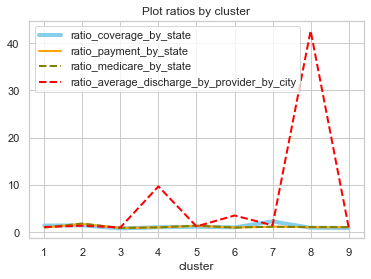

In [61]:
# group by cluster  
# y: last 4 columns
output9['cluster'] = [1,2,3,4,5,6,7,8, 9]

# multiple line plot
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output9, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output9, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.plot( 'cluster', 'ratio_medicare_by_state', data=output9, marker='', color='olive', linewidth=2, linestyle='dashed', label="ratio_medicare_by_state")
plt.plot( 'cluster', 'ratio_average_discharge_by_provider_by_city', data=output9, marker='', color='red', linewidth=2, linestyle='dashed', label="ratio_average_discharge_by_provider_by_city")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()


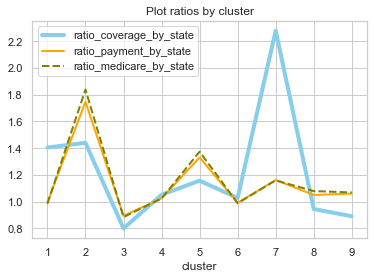

In [62]:
# if we do not plot the variable about discharges
# multiple line plot
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output9, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output9, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.plot( 'cluster', 'ratio_medicare_by_state', data=output9, marker='', color='olive', linewidth=2, linestyle='dashed', label="ratio_medicare_by_state")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()


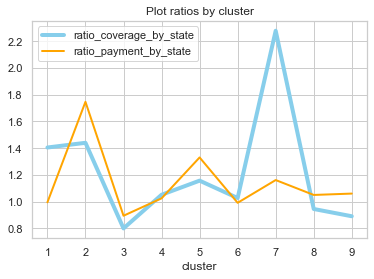

In [63]:
# we found ratio_payment_by_state and ratio_medicare_by_state are very similar, so we only keep one of them, ratio_payment_by_state
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output9, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output9, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()

### n_clusters = 10

- cluster 7 (0.01%) and cluster 10 (9.7%) has the least number of observations and the highest discharges
- cluster 5 has the 2nd least number of observations (6.8%), and relatively highest average ratio of total coverage and actual payment, health providers in this group requires more attention.

In [64]:
output10 = identify_outlier_by_kmeans(10, PCA_components, num_component=3)
output10['cluster'] = [1,2,3,4,5,6,7,8,9,10]
output10

count  Total Discharges  Average Covered Charges  Average Total Payments  \
0  18757         38.306126             40838.894732            12181.415047   
1  39045         27.200948             28061.117003             8598.478955   
2  16302        110.239357             28282.371676             7756.589804   
3  41999         29.893402             28778.172007             9443.900957   
4   1109         42.084761             78363.575356            21428.277935   
5   7051         45.049638             71982.723991            10541.078237   
6     32        990.062500             32458.195938            10219.317187   
7   8406         44.671901             42002.687473            14455.545128   
8  28769         31.267475             46642.165483             8894.655547   
9   1595        295.353605             44132.295078            12434.295273   

   Average Medicare Payments  ratio_coverage_by_state  ratio_payment_by_state  \
0               10833.752037                 1.112300                1.256292   
1                7500.680175                 0.790242                0.882703   
2                6611.562629                 1.025662                0.990144   
3                8263.811568                 0.865941                1.034987   
4               19323.903075                 2.132747                2.108757   
5                9195.948579                 2.215016                1.146153   
6                8792.948125                 0.944469                1.049660   
7               13077.245297                 1.275693                1.573200   
8                7667.963021                 1.383488                0.986811   
9               10751.561285                 1.052134                1.023892   

   ratio_medicare_by_state  ratio_average_discharge_by_provider_by_city  \
0                 1.286050                                     1.181442   
1                 0.871508                                     1.012164   
2                 0.987221                                     3.551992   
3                 1.041331                                     1.013000   
4                 2.177398                                     1.328835   
5                 1.141865                                     1.450215   
6                 1.078732                                    42.649894   
7                 1.657667                                     1.336826   
8                 0.975625                                     1.099235   
9                 1.022497                                     9.724668   

   cluster  
0        1  
1        2  
2        3  
3        4  
4        5  
5        6  
6        7  
7        8  
8        9  
9       10

In [65]:
# percentage of clusters
7051/163065

0.04324042559715451

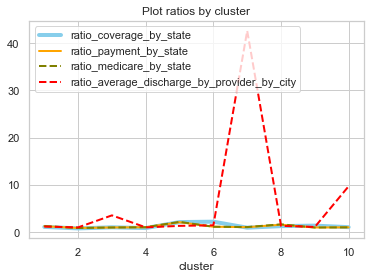

In [66]:
# group by cluster  
# y: last 4 columns
# multiple line plot
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output10, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output10, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.plot( 'cluster', 'ratio_medicare_by_state', data=output10, marker='', color='olive', linewidth=2, linestyle='dashed', label="ratio_medicare_by_state")
plt.plot( 'cluster', 'ratio_average_discharge_by_provider_by_city', data=output10, marker='', color='red', linewidth=2, linestyle='dashed', label="ratio_average_discharge_by_provider_by_city")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()


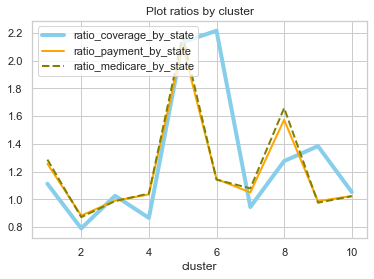

In [67]:
# if we do not plot the variable about discharges

# multiple line plot
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output10, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output10, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.plot( 'cluster', 'ratio_medicare_by_state', data=output10, marker='', color='olive', linewidth=2, linestyle='dashed', label="ratio_medicare_by_state")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()

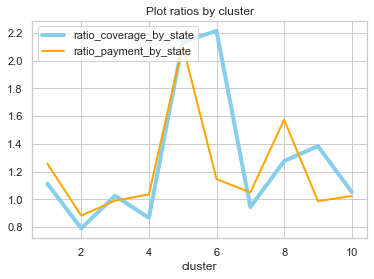

In [68]:
plt.plot( 'cluster', 'ratio_coverage_by_state', data=output10, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="ratio_coverage_by_state")
plt.plot( 'cluster', 'ratio_payment_by_state', data=output10, marker='', color='orange', linewidth=2,label="ratio_payment_by_state")
plt.xlabel('cluster')
plt.title('Plot ratios by cluster')
plt.legend(loc='upper left')
plt.show()

# 5. Conclusion

- the identified cluster when k = 10 has reasonable observations and differentiation compared with other clusters

- cluster 5 contains 6.8% observations, in this cluster, health providers has 2 times higher actual total payment compared to the median level in this state, and 2.1 times higher coverage compared to state median
